In [1]:
## ライブラリのインポート
import matplotlib.pyplot as plt
import numpy as np
import time
import random
from qulacs import QuantumState
from qulacs.state import inner_product
from qulacs import QuantumCircuit
from qulacs.gate import to_matrix_gate
from qulacs import QuantumState
from qulacs.gate import Identity, X,Y,Z #パウリ演算子
from qulacs.gate import H
from qulacs.gate import RX,RY,RZ #パウリ演算子についての回転演算

## 理想的な回路作成

In [2]:
# 係数の絶対値の分布をプロットする関数
def show_distribution(state, nqubits):
    plt.bar([i for i in range(pow(2, nqubits))], abs(state.get_vector()))

### 動作の確認
まずは5量子ビットのアルゴリズムを実装し、動作を確認する。

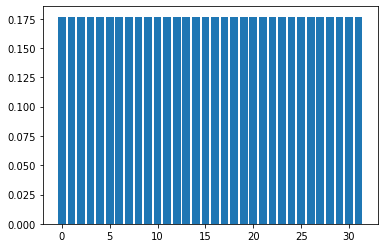

In [3]:
nqubits = 5
state = QuantumState(nqubits)
state.set_zero_state()

def make_Hadamard(nqubits):
    Hadamard = QuantumCircuit(nqubits)
    for i in range(nqubits):
        Hadamard.add_gate(H(i))
    return  Hadamard

Hadamard = make_Hadamard(nqubits)
Hadamard.update_quantum_state(state)

show_distribution(state, nqubits)

In [4]:
# オラクルU_wの作成
def make_U_w(nqubits):
    U_w = QuantumCircuit(nqubits)
    CnZ = to_matrix_gate(Z(nqubits-1))
    # i-th qubitが全て1の場合だけゲートを作用
    for i in range(nqubits-1):
        control_index = i
        control_with_value = 1
        CnZ.add_control_qubit(control_index, control_with_value)
    U_w.add_gate(CnZ)
    return U_w

In [5]:
fuga = state.copy()
U_w = make_U_w(nqubits)
U_w.update_quantum_state(fuga)
print(fuga.get_vector())

[ 0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j]


In [6]:
# 反転U_sを作る
def make_U_s(nqubits):
    U_s = QuantumCircuit(nqubits)
    for i in range(nqubits):
        U_s.add_gate(H(i))

    ## 2|0><0| - I の実装
    U_s.add_gate(to_matrix_gate(RZ(nqubits-1, 2*np.pi))) ## まず、位相(-1)を全ての状態に付与する。ゲート行列はarrary([[-1,0],[0,-1]])
    U_s.add_gate( X(nqubits-1) )
    ## 全てのi-th qubitが0の場合だけZゲートを作用させる
    CnZ = to_matrix_gate(Z(nqubits-1))
    for i in range(nqubits-1):
        control_index = i
        control_with_value = 0
        CnZ.add_control_qubit(control_index, control_with_value)
    U_s.add_gate( CnZ )
    U_s.add_gate( X(nqubits-1) )

    for i in range(nqubits):
        U_s.add_gate(H(i))

    return U_s

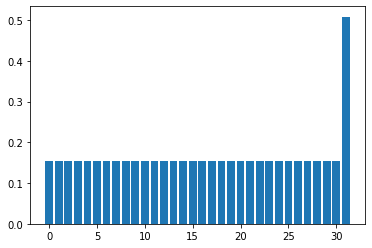

In [7]:
## 初期状態の準備
state = QuantumState(nqubits)
state.set_zero_state()
Hadamard.update_quantum_state(state)

## U_s U_w を作用
U_s = make_U_s(nqubits)
U_w.update_quantum_state(state)
U_s.update_quantum_state(state)
show_distribution(state,nqubits)

0.5082329989778305
0.7761601777867947
0.9470673343724091
0.9995910741614723


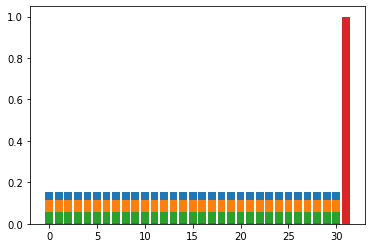

In [8]:
# 何回か繰り返す
## 内積を評価するために 解状態 |1...1> を作っておく
target_state = QuantumState(nqubits)
target_state.set_computational_basis(2**nqubits-1) ## 2**n_qubits-1 は 2進数で 1...1

## グローバーのアルゴリズムの実行
state = QuantumState(nqubits)
state.set_zero_state()

Hadamard.update_quantum_state(state)

result = []
for i in range(4):
    U_w.update_quantum_state(state)
    U_s.update_quantum_state(state)
    show_distribution(state,nqubits)
    fuga = np.linalg.norm(inner_product(state, target_state))
    result.append(fuga)
    print(fuga)

0.5082329989778305
0.7761601777867947
0.9470673343724091
0.9995910741614723
0.9271659296803515
0.738845043989187
0.4581685277993745
0.1202209456346408
0.23275425473442243
0.5566351732616823


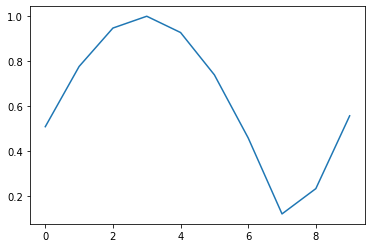

In [9]:
## 初期状態の準備
state = QuantumState(nqubits)
state.set_zero_state()
Hadamard.update_quantum_state(state)

result = []
times = 10
for i in range(times):
    U_w.update_quantum_state(state)
    U_s.update_quantum_state(state)
    # show_distribution(state,nqubits)
    fuga = np.linalg.norm(inner_product(state, target_state))
    result.append(fuga)
    print(fuga)

# plt.plot(np.arange(1, times+1), result, "o-")
plt.plot(result)

In [10]:
# グローバーのアルゴリズム
def grover(nqubits, operate_times):
    state = QuantumState(nqubits)
    state.set_zero_state()

    # 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2 ** nqubits - 1) # 2**n_qubits-1 は 2進数で 1...1

    # グローバーのアルゴリズムの実行
    Hadamard = make_Hadamard(nqubits)
    U_w = make_U_w(nqubits)
    U_s = make_U_s(nqubits)

    result = []

    state = QuantumState(nqubits)
    state.set_zero_state()
    Hadamard.update_quantum_state(state)
    for k in range(operate_times):
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        # show_distribution(state, nqubits)
        fuga = np.linalg.norm(inner_product(state, target_state))
        result.append(fuga)
        print(fuga)


    max_k = np.argmax(result)
    print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k + 1}')

    # plt.plot(np.arange(1, 30+1), result, "o-")
    plt.plot(result, "o-")

0.5082329989778305
0.7761601777867947
0.9470673343724091
0.9995910741614723
0.9271659296803515
0.738845043989187
0.4581685277993745
0.1202209456346408
0.23275425473442243
0.5566351732616823
maximal probability 9.995911e-01 is obtained at k = 4


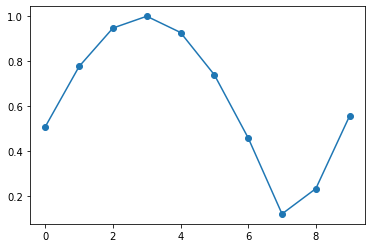

In [11]:
grover(5, 10)

ノイズを入れてみる。

In [12]:
from qulacs.gate import DephasingNoise

In [13]:
# オラクルU_wの作成
def make_noisy_U_w(nqubits, dephasing_rate):
    U_w = QuantumCircuit(nqubits)
    # DephasingNoise(0, dephasing_rate)
    CnZ = to_matrix_gate(Z(nqubits-1))
    # i-th qubitが全て1の場合だけゲートを作用
    for i in range(nqubits-1):
        DephasingNoise(i, dephasing_rate)
        control_index = i
        control_with_value = 1
        CnZ.add_control_qubit(control_index, control_with_value)
    U_w.add_gate(CnZ)
    return U_w

In [14]:
# 反転U_sを作る
def make_noisy_U_s(nqubits, dephasing_rate):
    U_s = QuantumCircuit(nqubits)
    # DephasingNoise(0, dephasing_rate)
    for i in range(nqubits):
        DephasingNoise(i, dephasing_rate)
        U_s.add_gate(H(i))

    ## 2|0><0| - I の実装
    U_s.add_gate(to_matrix_gate(RZ(nqubits-1, 2*np.pi))) ## まず、位相(-1)を全ての状態に付与する。ゲート行列はarrary([[-1,0],[0,-1]])
    U_s.add_gate( X(nqubits-1) )
    ## 全てのi-th qubitが0の場合だけZゲートを作用させる
    CnZ = to_matrix_gate(Z(nqubits-1))
    for i in range(nqubits-1):
        control_index = i
        control_with_value = 0
        CnZ.add_control_qubit(control_index, control_with_value)
    U_s.add_gate( CnZ )
    U_s.add_gate( X(nqubits-1) )

    for i in range(nqubits):
        U_s.add_gate(H(i))

    return U_s

In [15]:
# U_wにノイズのあるグローバーのアルゴリズムの関数化
def noisy_U_w_grover(nqubits, operate_times, dephasing_rate):
    state = QuantumState(nqubits)
    state.set_zero_state()

    # 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2 ** nqubits - 1) # 2**n_qubits-1 は 2進数で 1...1

    # グローバーのアルゴリズムの実行
    Hadamard = make_Hadamard(nqubits)
    # U_w = make_U_w(nqubits)
    U_w = make_noisy_U_w(nqubits, dephasing_rate)
    U_s = make_U_s(nqubits)

    result = []

    state = QuantumState(nqubits)
    state.set_zero_state()
    Hadamard.update_quantum_state(state)
    for k in range(operate_times):
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        # show_distribution(state, nqubits)
        fuga = np.linalg.norm(inner_product(state, target_state))
        result.append(fuga)
        print(fuga)


    max_k = np.argmax(result)
    print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k + 1}')

    # plt.plot(np.arange(1, 30+1), result, "o-")
    plt.plot(result, "o-")

0.5082329989778305
0.7761601777867947
0.9470673343724091
0.9995910741614723
0.9271659296803515
0.738845043989187
0.4581685277993745
0.1202209456346408
0.23275425473442243
0.5566351732616823
maximal probability 9.995911e-01 is obtained at k = 4


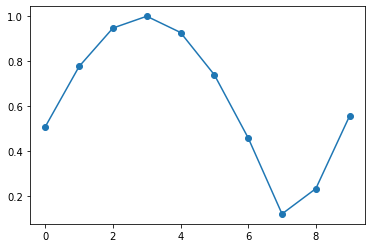

In [16]:
noisy_U_w_grover(5, 10, 0.5)

prob:0.0
0.5082329989778305
0.7761601777867947
0.9470673343724091
0.9995910741614723
0.9271659296803515
0.738845043989187
0.4581685277993745
0.1202209456346408
0.23275425473442243
0.5566351732616823
maximal probability 9.995911e-01 is obtained at k = 4
prob:0.1
0.5082329989778305
0.7761601777867947
0.9470673343724091
0.9995910741614723
0.9271659296803515
0.738845043989187
0.4581685277993745
0.1202209456346408
0.23275425473442243
0.5566351732616823
maximal probability 9.995911e-01 is obtained at k = 4
prob:0.2
0.5082329989778305
0.7761601777867947
0.9470673343724091
0.9995910741614723
0.9271659296803515
0.738845043989187
0.4581685277993745
0.1202209456346408
0.23275425473442243
0.5566351732616823
maximal probability 9.995911e-01 is obtained at k = 4
prob:0.30000000000000004
0.5082329989778305
0.7761601777867947
0.9470673343724091
0.9995910741614723
0.9271659296803515
0.738845043989187
0.4581685277993745
0.1202209456346408
0.23275425473442243
0.5566351732616823
maximal probability 9.9959

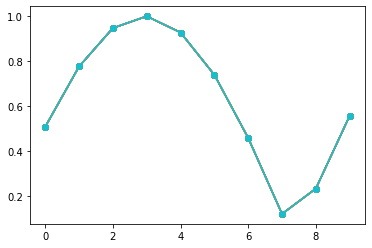

In [17]:
for prob in np.arange(0.0, 1.0, 0.1):
    print(f'prob:{prob}')
    noisy_U_w_grover(5, 10, prob)

In [18]:
# U_sにノイズのあるグローバーのアルゴリズムの関数化
def noisy_U_s_grover(nqubits, operate_times, dephasing_rate):
    state = QuantumState(nqubits)
    state.set_zero_state()

    # 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2 ** nqubits - 1) # 2**n_qubits-1 は 2進数で 1...1

    # グローバーのアルゴリズムの実行
    Hadamard = make_Hadamard(nqubits)
    U_w = make_U_w(nqubits)
    # U_s = make_U_s(nqubits)
    U_s = make_noisy_U_s(nqubits, dephasing_rate)

    result = []

    state = QuantumState(nqubits)
    state.set_zero_state()
    Hadamard.update_quantum_state(state)
    for k in range(operate_times):
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        # show_distribution(state, nqubits)
        fuga = np.linalg.norm(inner_product(state, target_state))
        result.append(fuga)
        print(fuga)


    max_k = np.argmax(result)
    print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k + 1}')

    # plt.plot(np.arange(1, 30+1), result, "o-")
    plt.plot(result, "o-")

0.5082329989778305
0.7761601777867947
0.9470673343724091
0.9995910741614723
0.9271659296803515
0.738845043989187
0.4581685277993745
0.1202209456346408
0.23275425473442243
0.5566351732616823
maximal probability 9.995911e-01 is obtained at k = 4


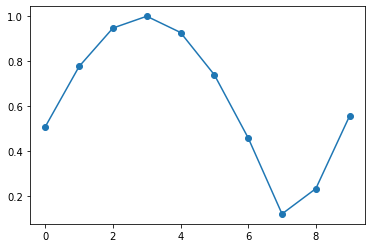

In [19]:
noisy_U_s_grover(5, 10, 0.5)

In [20]:
# 両方にノイズのあるグローバーのアルゴリズムの関数化
def noisy_U_grover(nqubits, operate_times, dephasing_rate):
    state = QuantumState(nqubits)
    state.set_zero_state()

    # 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2 ** nqubits - 1) # 2**n_qubits-1 は 2進数で 1...1

    # グローバーのアルゴリズムの実行
    Hadamard = make_Hadamard(nqubits)
    # U_w = make_U_w(nqubits)
    U_w = make_noisy_U_w(nqubits, dephasing_rate)
    # U_s = make_U_s(nqubits)
    U_w = make_noisy_U_s(nqubits, dephasing_rate)

    result = []

    state = QuantumState(nqubits)
    state.set_zero_state()
    Hadamard.update_quantum_state(state)
    for k in range(operate_times):
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        # show_distribution(state, nqubits)
        fuga = np.linalg.norm(inner_product(state, target_state))
        result.append(fuga)
        print(fuga)


    max_k = np.argmax(result)
    print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k + 1}')

    # plt.plot(np.arange(1, 30+1), result, "o-")
    plt.plot(result, "o-")

0.17677669529663653
0.17677669529663625
0.17677669529663598
0.1767766952966357
0.17677669529663542
0.17677669529663514
0.17677669529663487
0.1767766952966346
0.1767766952966343
0.17677669529663403
maximal probability 1.767767e-01 is obtained at k = 1


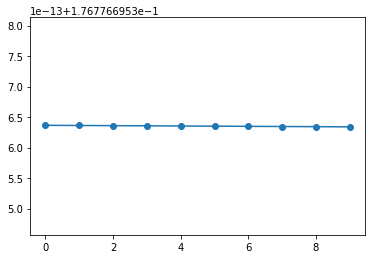

In [21]:
noisy_U_grover(5, 10, 0.5)

dephasing_rate: 0.0
0.17677669529663653
0.17677669529663625
0.17677669529663598
0.1767766952966357
0.17677669529663542
0.17677669529663514
0.17677669529663487
0.1767766952966346
0.1767766952966343
0.17677669529663403
maximal probability 1.767767e-01 is obtained at k = 1
dephasing_rate: 0.1
0.17677669529663653
0.17677669529663625
0.17677669529663598
0.1767766952966357
0.17677669529663542
0.17677669529663514
0.17677669529663487
0.1767766952966346
0.1767766952966343
0.17677669529663403
maximal probability 1.767767e-01 is obtained at k = 1
dephasing_rate: 0.2
0.17677669529663653
0.17677669529663625
0.17677669529663598
0.1767766952966357
0.17677669529663542
0.17677669529663514
0.17677669529663487
0.1767766952966346
0.1767766952966343
0.17677669529663403
maximal probability 1.767767e-01 is obtained at k = 1
dephasing_rate: 0.30000000000000004
0.17677669529663653
0.17677669529663625
0.17677669529663598
0.1767766952966357
0.17677669529663542
0.17677669529663514
0.17677669529663487
0.1767766952

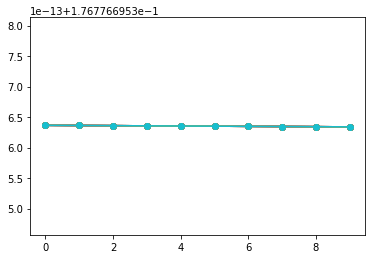

In [26]:
for i in np.arange(0.0, 1.0, 0.1):
    print(f'dephasing_rate: {i}')
    noisy_U_grover(5, 10, i)

#### TODO: ノイズは以下の方法で入れた方が良いのではないか？

https://docs.qulacs.org/ja/latest/guide/2.0_python_advanced.html#noisesimulator